<p style="font-size:30px; text-align:center; line-height:120%">
<br>
Modeling Disease Progression Using CT-HMM <br>
CBMF W4761 - Computational Genomics<br>
Steve Marquez<br>
Spring 2024<br>
</p>

In [1]:
# libraries for the CT-HMM
import numpy as np
from scipy import linalg as la
from scipy.stats import gamma
from scipy.special import digamma, polygamma


# libraries for the bootstrapping analysis
from sklearn.utils import resample
from collections import defaultdict
import random
import pandas as pd

# data visualization
import matplotlib.pyplot as plt

In [2]:
class CT_HMM():
    def __init__(self, data, time_intervals, transition_matrix, start_prob, g_shape, g_scale):
        self.sequence = data
        self.time_intervals = time_intervals
        self.q = np.array(transition_matrix)
        self.n_states = np.shape(self.q)[0]
        self.gamma_shape = g_shape
        self.gamma_scale = g_scale
        self.init_prob = self.format_init_probs(start_prob)
        self.emiss_probs = self.format_emiss_probs(data)
        self.trans_probs_given_time = self.format_trans_probs_gt()
        self.trans_probs_all_time = self.format_trans_probs_anyt()
        
########################################################################################################################
    # helper functions
    def format_trans_probs_gt(self):
        trans_probs_gt = dict()
        for time in self.time_intervals.values():
            for t in range(len(time)):
                if time[t]:
                    trans_probs_gt[time[t]] = la.expm(self.q * float(time[t]))
        return trans_probs_gt

    def format_trans_probs_anyt(self):
        trans_prob_anyt = dict()
        for time in self.time_intervals.values():
            for t in range(len(time)):
                if time[t] is not None:
                    trans_prob_anyt[time[t]] = dict()
                    for state in range(self.n_states):
                        trans_prob_anyt[time[t]][state] = dict()
        for item in trans_prob_anyt:
            trans_prob_anyt[item] = np.zeros((self.n_states, self.n_states))
        return trans_prob_anyt
    
    def format_init_probs(self, s_probs):
        init_probs = dict()
        for i in range (len(s_probs)):
            init_probs[i] = s_probs[i]
        return init_probs

    def format_emiss_probs(self, data):
        # create a dictionary with the emission probabilities
        emiss_probs = dict()
        for state in range(self.n_states):
            emiss_probs[state] = dict()

        # apply the gamma distribution to the emission probabilities
        for sequence in data:
            for i in range(len(data[sequence])):
                for state in range(self.n_states):
                    emiss_probs[state][(data[sequence][i])] = gamma.pdf(float(data[sequence][i]),
                                                                        a=self.gamma_shape[state],
                                                                        scale=self.gamma_scale[state])
                    if emiss_probs[state][(data[sequence][i])] == 0:
                        emiss_probs[state][(data[sequence][i])] = 1e-300
        return emiss_probs

    def format_exp_time(self):
        et = dict()
        init_1 = np.zeros((self.n_states, self.n_states))
        init_2 = np.zeros((self.n_states, self.n_states, self.n_states))
        for i in range(self.n_states):
            et[i] = 0

        format_exmp = dict()
        for j in self.trans_probs_all_time:
            m = [0] * self.n_states
            m = np.array(m)
            m = m.reshape(1, self.n_states)
            for k in range(self.n_states):
                temp = np.array(self.trans_probs_all_time[j][k])
                temp = temp.reshape(1, self.n_states)
                m = np.append(m, temp, axis=0)
            m = np.delete(m, list(range(0, self.n_states)))
            m = m.reshape(self.n_states, self.n_states)
            format_exmp[j]= m
        for i in range(self.n_states):
            for time in self.trans_probs_all_time:
                m = np.zeros((self.n_states, self.n_states))
                m[i][i] = 1
                n = np.bmat(([self.q, m], [init_1, self.q]))
                init_2[i] = ((la.expm(n * float(time)))[0:self.n_states, self.n_states:2*self.n_states]) / (self.trans_probs_given_time[time])
                et[i] += (format_exmp[time] * init_2[i]).sum().sum()
        return et

    def format_exp_n_transitions(self):
        ent = dict()
        init = np.zeros((self.n_states, self.n_states))

        for i in range(self.n_states):
            ent[i] = dict()
            for j in range(self.n_states):
                ent[i][j] = 0

        format_exmp = dict()
        for j in self.trans_probs_all_time:
            m = [0] * self.n_states
            m = np.array(m)
            m = m.reshape(1, self.n_states)
            for k in range(self.n_states):
                temp = np.array(self.trans_probs_all_time[j][k])
                temp = temp.reshape(1, self.n_states)
                m = np.append(m, temp, axis=0)
            m = np.delete(m, list(range(0, self.n_states)))
            m = m.reshape(self.n_states, self.n_states)
            format_exmp[j]= m

        for i in range(self.n_states):
            for j in range(self.n_states):
                for time in self.trans_probs_all_time:
                    m = np.zeros((self.n_states, self.n_states))
                    m[i][j] = 1
                    n = np.bmat([[self.q, m], [init, self.q]])
                    l = self.q[i][j] * (la.expm(n * float(time))[0:self.n_states, self.n_states:2 * self.n_states]) / (self.trans_probs_given_time[time])
                    ent[i][j] += (format_exmp[time] * l).sum().sum()
        return ent

    def newtonian_step(self, param, xbar, logxbar):
        parameter = param
        if parameter <= 0:
            parameter = 1e-20
        if (1 / parameter - polygamma(1, parameter)) == 0:
            updated_params = 0
        else:
            updated_params = (np.log(parameter) - digamma(parameter) - np.log(xbar) + logxbar) / (1 / parameter - polygamma(1, parameter))
        update = parameter - updated_params
        return update



    def gamma_MLE(self, xbar, logxbar, sequence):
        CONVERGENCE_METRIC = 0.0001
        denom = 0
        obsv_counter = 0
        for obsv in sequence.values():
            for value in obsv:
                denom += (float(value) - xbar)**2
                obsv_counter += 1
        moment_estimator = (obsv_counter * xbar**2) / (denom)
        mom = [moment_estimator]
        mom.append(self.newtonian_step(mom[0], xbar, logxbar))
        iteration = 1
        while (abs(mom[iteration] - mom[iteration-1]) > CONVERGENCE_METRIC):
            if (iteration > 10_000): raise ValueError("Max Iterations Exceeded")
            mom.append(self.newtonian_step(mom[iteration], xbar, logxbar))
            iteration += 1
        theta = xbar/mom[iteration-1]
        return mom[-1], theta

##################################################################################################################
    # functions for CT-HMM
    def forward(self):
        fwd = dict()
        for t in self.time_intervals:
            fwd[t] = dict()
            for state in range(self.n_states):
                fwd[t][state] = [0] * len(self.sequence[t])
                fwd[t][state][0] = self.init_prob[state] * self.emiss_probs[state][self.sequence[t][0]]

            obsv_counter = 1
            for time in self.time_intervals[t]:
                if time is not None:
                    for state in range(self.n_states):
                        sum_transition_probs = 0
                        for i in range(self.n_states):
                            trans_prob = fwd[t][i][obsv_counter-1] * self.trans_probs_given_time[time][i][state]
                            sum_transition_probs += trans_prob
                        fwd[t][state][obsv_counter] = (self.emiss_probs[state][self.sequence[t][obsv_counter]]
                                                       * sum_transition_probs)
                    obsv_counter += 1
        return fwd

    def backward(self):
        bwd = dict()
        for t in self.time_intervals:
            bwd[t] = dict()
            for state in range(self.n_states):
                bwd[t][state] = [0] * len(self.sequence[t])
                bwd[t][state][len(self.sequence[t]) - 1] = 1

            obsv_counter = len(self.sequence[t]) - 2
            for time in reversed(self.time_intervals[t]):
                if time is not None:
                    for state in range(self.n_states):
                        sum_transition_probs = 0
                        for i in range(self.n_states):
                            sum_transition_probs += (self.trans_probs_given_time[time][state][i]
                                                     * self.emiss_probs[i][self.sequence[t][obsv_counter+1]]
                                                     * bwd[t][i][obsv_counter + 1])
                            bwd[t][state][obsv_counter] = sum_transition_probs
                obsv_counter -= 1
        return bwd

    def exp_max(self, post_prob):
        et = self.format_exp_time()
        ent = self.format_exp_n_transitions()

        for i in range(self.n_states):
            total = 0
            for j in range(self.n_states):
                if (i != j):
                    self.q[i][j] = ent[i][j] / et[j]
                    total += self.q[i][j]
            self.q[i][i] = total * -1
        
        assert(not [row for row in range(len(self.q)) if round(sum(self.q[row]), 3) != 0])

        # we are updating the gamma shape and scale
        xbar = [0] * self.n_states
        logxbar = [0] * self.n_states
        sum_numx = [0] * self.n_states
        sum_denom = [0] * self.n_states
        sum_num_logx = [0] * self.n_states
        for sequence in self.sequence:
            for i in range(len(self.sequence[sequence])):
                for j in range(self.n_states):
                    sum_numx[j] += post_prob[sequence][j][i] * float(self.sequence[sequence][i])
                    sum_denom[j] += post_prob[sequence][j][i]
                    sum_num_logx[j] += post_prob[sequence][j][i] * np.log(float(self.sequence[sequence][i]))
        new_init_probs = np.zeros((self.n_states, 1))
        for i in range(self.n_states):
            for sequence in self.sequence:
                new_init_probs[i] += post_prob[sequence][i][1]
        init_probs_denom = sum(new_init_probs)
        for i in range(self.n_states):
            self.init_prob[i] = new_init_probs[i]/init_probs_denom
        for i in range(self.n_states):
            xbar[i] = sum_numx[i] / sum_denom[i]
            logxbar[i] = sum_num_logx[i] / sum_denom[i]
            self.gamma_shape[i], self.gamma_scale[i] = self.gamma_MLE(xbar[i], logxbar[i], self.sequence)
        return self.q

    def likelihood(self, f, b):
        sequence_likelihood = dict()

        temp_trans_matrix = dict()
        for _ in self.time_intervals.values():
            for time in range(len(_)):
                if _[time] is not None:
                    temp_trans_matrix[_[time]] = dict()

        for t in self.time_intervals:
            sequence_likelihood[t] = 0
            likelihood = 0
            for state in range(self.n_states):
                likelihood += f[t][state][-1]
            if (likelihood <= 0):
                likelihood = 1e-10
            sequence_likelihood[t] = np.log10(likelihood)

            # we also have to update the probabity of transition for all time
            counter = 0
            for interval in self.time_intervals[t]:
                if interval:
                    denom = 0
                    temp_trans_matrix[interval] = np.zeros((self.n_states, self.n_states))
                    for i in range(self.n_states):
                        for j in range(self.n_states):
                            temp_trans_prob = (f[t][i][counter] * self.trans_probs_given_time[interval][i][j]
                                               * self.emiss_probs[j][self.sequence[t][counter+1]]
                                               * b[t][j][counter+1])
                            temp_trans_matrix[interval][i][j] += temp_trans_prob
                            denom += temp_trans_prob
                    for k in range(self.n_states):
                        for l in range(self.n_states):
                            if (denom == 0):
                                denom = 1e-10
                            temp_trans_matrix[interval][k][l] = temp_trans_matrix[interval][k][l] / denom
                            self.trans_probs_all_time[interval][k][l] += temp_trans_matrix[interval][k][l]
                    counter += 1

        log_likelihood = 0
        for ll in sequence_likelihood:
            log_likelihood += sequence_likelihood[ll]

        return log_likelihood

    def posterior_probability(self, f, b):
        post = dict()
        obsv_likelihood = dict()
        for t in self.time_intervals:
            post[t] = dict()
            obsv_likelihood[t] = [0] * len(self.sequence[t])

            for i in range(len(self.sequence[t])):
                total = 0
                for j in range(self.n_states):
                    total += (f[t][j][i] * b[t][j][i])
                obsv_likelihood[t][i] = total

            for i in range(self.n_states):
                post[t][i] = [0] * len(self.sequence[t])
                for j in range(len(self.sequence[t])):
                    if (obsv_likelihood[t][j] == 0):
                        post[t][i][j] = 1e-10
                    else:
                        post[t][i][j] = (f[t][i][j] * b[t][i][j]) / obsv_likelihood[t][j]
        return post


##################################################################################################################
    def train_model(self):
        CONVERGENCE_METRIC = 0.0001
        log_likelihood = list()

        fwd = self.forward()
        bwd = self.backward()
        pp = self.posterior_probability(fwd, bwd)
        final_loglikelihood = self.likelihood(fwd, bwd)
        update_parameters = self.exp_max(pp)
        log_likelihood.append(final_loglikelihood)

        fwd = self.forward()
        bwd = self.backward()
        pp = self.posterior_probability(fwd, bwd)
        final_loglikelihood = self.likelihood(fwd, bwd)
        update_parameters = self.exp_max(pp)
        log_likelihood.append(final_loglikelihood)

        i = 1
        while (abs(log_likelihood[i] - log_likelihood[i-1]) > CONVERGENCE_METRIC):
            fwd = self.forward()
            bwd = self.backward()
            pp = self.posterior_probability(fwd, bwd)
            final_loglikelihood = self.likelihood(fwd, bwd)
            update_parameters = self.exp_max(pp)
            log_likelihood.append(final_loglikelihood)
            i = i + 1

        final_num_parameters = 2 * len(self.gamma_shape) + (len(self.gamma_shape) * len(self.gamma_shape)) - 1
        aic_score = (2 * final_num_parameters) - (2 * log_likelihood[-1])
        num_observations = sum(len(x) for x in self.sequence.values())
        bic_score = (final_num_parameters * np.log(num_observations)) - (2 * log_likelihood[-1])
        return (self.init_prob, update_parameters, log_likelihood,
                aic_score, bic_score, 
                self.gamma_shape, self.gamma_scale)
    

In [3]:
def bootstrap(dataset, intervals):
    iterations = 1_000
    sample_size = int(len(dataset[0]))

    # for transition probabilities
    trans_00 = list()
    trans_01 = list()
    trans_02 = list()
    trans_10 = list()
    trans_11 = list()
    trans_12 = list()
    trans_20 = list()
    trans_21 = list()
    trans_22 = list()

    # for emission probabilities
    shape_1 = list()
    shape_2 = list()
    shape_3 = list()
    scale_1 = list()
    scale_2 = list()
    scale_3 = list()
    mean_1 = list()
    mean_2 = list()
    mean_3 = list()

    # other
    aic_scores = list()
    bic_scores = list()
    init_prob_1 = list()
    init_prob_2 = list()
    init_prob_3 = list()
    
    
    #fix the time stuff
    for i in range (iterations):
        results = list()
        for data in dataset:
            sample = resample(list(data.keys()), n_samples=sample_size)
            sequence = dict()
            time = dict()
            for key in sample:
                # allowing for duplicated samples
                if key in sequence.keys():
                    new_key = key + str(random.randrange(int(len(data)*2)))
                    sequence[new_key] = data[key]
                    time[new_key] = intervals[key]
                else:
                    sequence[key] = data[key]
                    time[key] = intervals[key]

            estimate_trans_mat = [[-0.892, 0.729, 0.163],
                              [0.814, -1.016, 0.202],
                              [0.163, 0.276, -0.439]]
            estimate_init_probs = [0.6234, 0.2109, 0.1657]
            estimate_gamma_shape = [19.7254, 18.3060, 15.4033]
            estimate_gamma_scale = [0.3153, 0.2158, 0.2184]
            model = CT_HMM(sequence, time,  estimate_trans_mat, estimate_init_probs, estimate_gamma_shape, estimate_gamma_scale)
            init, trans_matrix, log_like, score_1, score_2, g_shape, g_scale = model.train_model()
            results.append([init, trans_matrix, log_like, score_1, score_2, g_shape, g_scale])

        
        init_probs_results = [a * b * c for a, b, c in zip(results[0][0], results[1][0], results[2][0])]
        init_prob_1.append(init_probs_results[0])
        init_prob_2.append(init_probs_results[1])
        init_prob_3.append(init_probs_results[2])

        trans_matrix_results = [a * b * c for a, b, c in zip(results[0][1], results[1][1], results[2][1])]
        trans_00.append(trans_matrix_results[0][0])
        trans_01.append(trans_matrix_results[0][1])
        trans_02.append(trans_matrix_results[0][2])

        trans_10.append(trans_matrix_results[1][0])
        trans_11.append(trans_matrix_results[1][1])
        trans_12.append(trans_matrix_results[1][2])
        
        trans_20.append(trans_matrix_results[2][0])
        trans_21.append(trans_matrix_results[2][1])
        trans_22.append(trans_matrix_results[2][2])
        

        g_shape_results = [(a * b * c)/3 for a, b, c in zip(results[0][1], results[1][1], results[2][1])]
        shape_1.append(g_shape_results[0])
        shape_2.append(g_shape_results[1])
        shape_3.append(g_shape_results[2])

        g_scale_results = [(a * b * c)/3 for a, b, c in zip(results[0][1], results[1][1], results[2][1])]
        scale_1.append(g_scale_results[0])
        scale_2.append(g_scale_results[1])
        scale_3.append(g_scale_results[2])

        
        mean_1.append(g_shape[0] * g_scale[0])
        mean_2.append(g_shape[1] * g_scale[1])
        mean_3.append(g_shape[2] * g_scale[2])

        score_1_results = [a + b + c for a, b, c in zip(results[0][3], results[1][3], results[2][3])]
        score_2_results = [a + b + c for a, b, c in zip(results[0][4], results[1][4], results[2][4])]
        aic_scores.append(score_1_results)
        bic_scores.append(score_2_results)

    trans_matrix = [trans_00, trans_01, trans_02,
                    trans_10, trans_11, trans_12,
                    trans_20, trans_21, trans_22]
    shapes = [shape_1, shape_2, shape_3]
    scales = [scale_1, scale_2, scale_3]
    mean = [mean_1, mean_2, mean_3]
    init = [init_prob_1, init_prob_2, init_prob_3]
    outcome = [trans_matrix, shapes, scales, mean, init, aic_scores, bic_scores]
    return outcome


In [4]:
def analyize(list_results):
    # we want confidence_interval => 0.95
    a = 0.05
    lower_percentile = (a / 2) * 100
    upper_percentile = (1 - a + (a / 2)) * 100

    # lists to store the data bounded by the percentile
    trans_lower = [np.percentile(trans, lower_percentile) for trans in list_results[0]]
    trans_upper = [np.percentile(trans, upper_percentile) for trans in list_results[0]]

    shape_lower = [np.percentile(shape, lower_percentile) for shape in list_results[1]]
    shape_upper = [np.percentile(shape, upper_percentile) for shape in list_results[1]]
    scale_lower = [np.percentile(scale, lower_percentile) for scale in list_results[2]]
    scale_upper = [np.percentile(scale, upper_percentile) for scale in list_results[2]]

    mean_lower = [np.percentile(mean, lower_percentile) for mean in list_results[3]]
    mean_upper = [np.percentile(mean, upper_percentile) for mean in list_results[3]]

    init_lower = [max(0, np.percentile(init_prob, lower_percentile)) for init_prob in list_results[4]]
    init_upper = [min(1, np.percentile(init_prob, upper_percentile)) for init_prob in list_results[4]]


    trans_mat_parameters = ['trans_00', 'trans_01', 'trans_02',
                            'trans_10', 'trans_11', 'trans_12',
                            'trans_20', 'trans_12', 'trans_22']
    trans_df = pd.DataFrame({'parameters': trans_mat_parameters, 'lower': trans_lower, 'upper': trans_upper})

    shape_parameters = ['shape_1', 'shape_2', 'shape_3']
    scale_parameters = ['scale_1', 'scale_2', 'scale_3']
    shape_df = pd.DataFrame({'parameters': shape_parameters, 'lower': shape_lower, 'upper': shape_upper})
    scale_df = pd.DataFrame({'parameters': scale_parameters, 'lower': scale_lower, 'upper': scale_upper})

    init_prob_parameters = ['init_prob_1', 'init_prob_2', 'init_prob_3']
    ip_df = pd.DataFrame({'parameters': init_prob_parameters, 'lower': init_lower, 'upper': init_upper})


    mean_parameters = ['mean_1', 'mean_2', 'mean_3']
    mean_df = pd.DataFrame({'parameters': mean_parameters, 'lower': mean_lower, 'upper': mean_upper})

    dataframes = [trans_df, shape_df, scale_df, ip_df, mean_df]
    return dataframes

In [5]:
def process_data(df):
    # remove all columns that have no data on the proteins and convert 'NaN' values into None
    clean_df = df.copy()
    clean_df.replace({np.nan: None}, inplace=True)
    clean_df['Biomarker_1'] = np.log(df['Biomarker_1'])
    clean_df['Biomarker_2'] = np.log(df['Biomarker_2'])
    clean_df['Biomarker_3'] = np.log(df['Biomarker_3']) * -1
    return clean_df

In [6]:
def data_time_split(df, target):
    data = defaultdict(list)
    time = defaultdict(list)
    for index, row in df.iterrows():
        data[row['ID']].append(str(round(float(row[target]), 3)))
        time[row['ID']].append(row['Time'])

    return data, time

In [7]:
def main():
    df = pd.read_csv('synthetic_data.csv')
    file = process_data(df)
    
    data_1, time_intervals = data_time_split(file, 'Biomarker_1')
    data_2, time_intervals = data_time_split(file, 'Biomarker_2') 
    data_3, time_intervals = data_time_split(file, 'Biomarker_3')
    
    results = bootstrap([data_1, data_2, data_3], time_intervals)
    df_results  = analyize(results)

    outcome = [results, df_results]
    return outcome

In [8]:
call = main()

# Results:

<b> Visualizing the dataset: </b>

In [9]:
# Visualizing the Dataset
df = pd.read_csv('synthetic_data.csv')
clean_df = df.copy()
clean_df.replace({np.nan: None}, inplace=True)
clean_df['Biomarker_1'] = np.log(df['Biomarker_1'])
clean_df['Biomarker_2'] = np.log(df['Biomarker_2'])
clean_df['Biomarker_3'] = np.log(df['Biomarker_3']) * -1
clean_df

,ID,Previous Diagnostic,Current Diagnostic,Biomarker_1,Biomarker_2,Biomarker_3,Time
0,01_,Symptomatic,Symptomatic,5.726848,5.384495,1.933784,None
1,01_,Symptomatic,Symptomatic,5.703782,5.384495,1.958286,1.0
2,01_,Symptomatic,Symptomatic,5.723585,5.393628,1.839480,1.0
3,01_,Symptomatic,Symptomatic,5.713733,5.402677,1.893792,1.0
4,01_,Symptomatic,Symptomatic,5.713733,5.393628,1.897120,4.0
...,...,...,...,...,...,...,...
144,21_,Healthy,Healthy,5.521461,4.762174,4.350528,4.0
145,22_,Critical,Critical,5.370638,5.384495,1.409768,None
146,22_,Critical,Critical,5.370638,5.370638,1.342852,1.0
147,22_,Critical,Critical,5.351858,5.375278,1.299016,3.0


Text(0, 0.5, 'AIC Score')

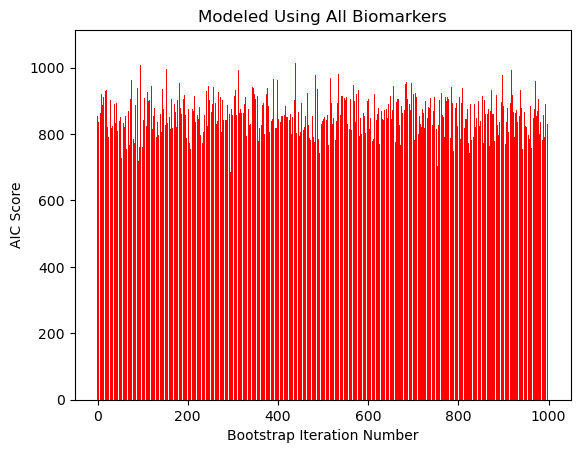

In [10]:
plt.bar(list(range(len(call[0][5]))), np.array(call[0][5]).flatten(), color='red')
plt.title('Modeled Using All Biomarkers')
plt.xlabel('Bootstrap Iteration Number') 
plt.ylabel('AIC Score') 

Text(0, 0.5, 'BIC Score')

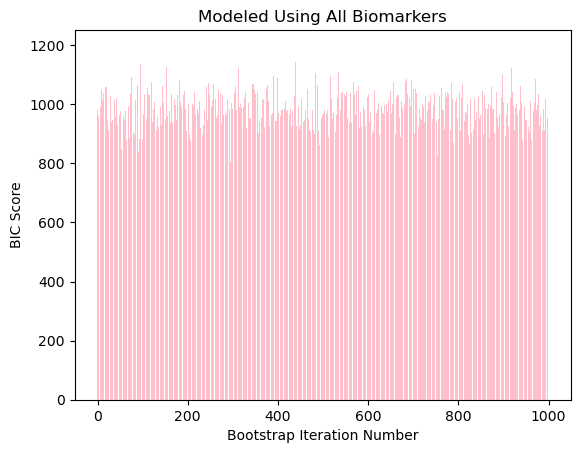

In [11]:
plt.bar(list(range(len(call[0][6]))), np.array(call[0][6]).flatten(), color='pink')
plt.title('Modeled Using All Biomarkers')
plt.xlabel('Bootstrap Iteration Number') 
plt.ylabel('BIC Score') 

In [12]:
# Obtiaining the Confidence Intervals
print('Obtiaining the Confidence Intervals for All Biomarkers\n')
for i in range(5):
    print(call[1][i])
    print('\n')

Obtiaining the Confidence Intervals for All Biomarkers

  parameters     lower     upper
0   trans_00 -1.816235 -1.377485
1   trans_01  0.665151  0.823504
2   trans_02  0.000790  0.015196
3   trans_10  0.424627  0.509950
4   trans_11 -1.286425 -1.111143
5   trans_12  0.000737  0.010194
6   trans_20  0.001190  0.004161
7   trans_12  0.004921  0.010437
8   trans_22 -0.058835 -0.022088


  parameters     lower     upper
0    shape_1 -0.585446  0.265664
1    shape_2 -0.419999  0.165929
2    shape_3 -0.017235  0.003226


  parameters     lower     upper
0    scale_1 -0.585446  0.265664
1    scale_2 -0.419999  0.165929
2    scale_3 -0.017235  0.003226


    parameters  lower  upper
0  init_prob_1    0.0    0.0
1  init_prob_2    1.0    1.0
2  init_prob_3    8.0    1.0


  parameters     lower     upper
0     mean_1  3.946546  4.172395
1     mean_2  3.593851  3.864320
2     mean_3  2.182900  2.866176




<b> Bootstrap method for pairs of biomarkers: </b>

In [13]:
def bootstrap_2D(dataset, intervals):
    iterations = 1_000
    sample_size = int(len(dataset[0]))

    # for transition probabilities
    trans_00 = list()
    trans_01 = list()
    trans_02 = list()
    trans_10 = list()
    trans_11 = list()
    trans_12 = list()
    trans_20 = list()
    trans_21 = list()
    trans_22 = list()

    # for emission probabilities
    shape_1 = list()
    shape_2 = list()
    shape_3 = list()
    scale_1 = list()
    scale_2 = list()
    scale_3 = list()
    mean_1 = list()
    mean_2 = list()
    mean_3 = list()

    # other
    aic_scores = list()
    bic_scores = list()
    init_prob_1 = list()
    init_prob_2 = list()
    init_prob_3 = list()

    #fix the time stuff
    for i in range (iterations):
        results = list()
        for data in dataset:
            sample = resample(list(data.keys()), n_samples=sample_size)
            sequence = dict()
            time = dict()
            for key in sample:
                # allowing for duplicated samples
                if key in sequence.keys():
                    new_key = key + str(random.randrange(int(len(data)*2)))
                    sequence[new_key] = data[key]
                    time[new_key] = intervals[key]
                else:
                    sequence[key] = data[key]
                    time[key] = intervals[key]

            estimate_trans_mat = [[-0.892, 0.729, 0.163],
                              [0.814, -1.016, 0.202],
                              [0.163, 0.276, -0.439]]
            estimate_init_probs = [0.6234, 0.2109, 0.1657]
            estimate_gamma_shape = [19.7254, 18.3060, 15.4033]
            estimate_gamma_scale = [0.3153, 0.2158, 0.2184]
            model = CT_HMM(sequence, time,  estimate_trans_mat, estimate_init_probs, estimate_gamma_shape, estimate_gamma_scale)
            init, trans_matrix, log_like, score_1, score_2, g_shape, g_scale = model.train_model()
            results.append([init, trans_matrix, log_like, score_1, score_2, g_shape, g_scale])

        
        init_probs_results = [a * b for a, b in zip(results[0][0], results[1][0])]
        init_prob_1.append(init_probs_results[0])
        init_prob_2.append(init_probs_results[1])
        init_prob_3.append(init_probs_results[2])

        trans_matrix_results = [a * b for a, b in zip(results[0][1], results[1][1])]
        trans_00.append(-1 * trans_matrix_results[0][0])
        trans_01.append(trans_matrix_results[0][1])
        trans_02.append(trans_matrix_results[0][2])

        trans_10.append(trans_matrix_results[1][0])
        trans_11.append(-1 * trans_matrix_results[1][1])
        trans_12.append(trans_matrix_results[1][2])
        
        trans_20.append(trans_matrix_results[2][0])
        trans_21.append(trans_matrix_results[2][1])
        trans_22.append(-1 * trans_matrix_results[2][2])
        

        g_shape_results = [(a * b)/2 for a, b in zip(results[0][1], results[1][1])]
        shape_1.append(g_shape_results[0])
        shape_2.append(g_shape_results[1])
        shape_3.append(g_shape_results[2])

        g_scale_results = [(a * b)/2 for a, b in zip(results[0][1], results[1][1])]
        scale_1.append(g_scale_results[0])
        scale_2.append(g_scale_results[1])
        scale_3.append(g_scale_results[2])

        
        mean_1.append(g_shape[0] * g_scale[0])
        mean_2.append(g_shape[1] * g_scale[1])
        mean_3.append(g_shape[2] * g_scale[2])

        score_1_results = [a + b for a, b in zip(results[0][3], results[1][3])]
        score_2_results = [a + b for a, b in zip(results[0][4], results[1][4])]
        aic_scores.append(score_1_results)
        bic_scores.append(score_2_results)

    trans_matrix = [trans_00, trans_01, trans_02,
                    trans_10, trans_11, trans_12,
                    trans_20, trans_21, trans_22]
    shapes = [shape_1, shape_2, shape_3]
    scales = [scale_1, scale_2, scale_3]
    mean = [mean_1, mean_2, mean_3]
    init = [init_prob_1, init_prob_2, init_prob_3]
    outcome = [trans_matrix, shapes, scales, mean, init, aic_scores, bic_scores]
    return outcome


In [14]:
def main_2():
    df = pd.read_csv('synthetic_data.csv')
    file = process_data(df)
    
    data_1, time_intervals = data_time_split(file, 'Biomarker_1')
    data_2, time_intervals = data_time_split(file, 'Biomarker_2') 
    
    results = bootstrap_2D([data_1, data_2], time_intervals)
    df_results  = analyize(results)

    outcome = [results, df_results]
    return outcome

In [15]:
call_2 = main_2()

In [16]:
print('Obtiaining the Confidence Intervals for Biomarker_1 with Biomarker_2')
for i in range(5):
    print(call_2[1][i])
    print('\n')

Obtiaining the Confidence Intervals for Biomarker_1 with Biomarker_2
  parameters     lower     upper
0   trans_00 -2.061084 -1.659110
1   trans_01  0.824624  0.975258
2   trans_02  0.138348  0.206995
3   trans_10  0.415467  0.472488
4   trans_11 -1.153004 -1.062484
5   trans_12  0.139268  0.160122
6   trans_20  0.006693  0.011397
7   trans_12  0.027289  0.036484
8   trans_22 -0.088671 -0.061647


  parameters     lower     upper
0    shape_1  0.072893  1.000982
1    shape_2  0.071073  0.568920
2    shape_3  0.003612  0.042244


  parameters     lower     upper
0    scale_1  0.072893  1.000982
1    scale_2  0.071073  0.568920
2    scale_3  0.003612  0.042244


    parameters  lower  upper
0  init_prob_1    0.0    0.0
1  init_prob_2    1.0    1.0
2  init_prob_3    4.0    1.0


  parameters     lower     upper
0     mean_1  5.155386  5.303058
1     mean_2  4.970971  5.179592
2     mean_3  4.914992  5.119208




In [17]:
def main_3():
    df = pd.read_csv('synthetic_data.csv')
    file = process_data(df)
    
    data_1, time_intervals = data_time_split(file, 'Biomarker_1')
    data_2, time_intervals = data_time_split(file, 'Biomarker_3') 
    
    results = bootstrap_2D([data_1, data_2], time_intervals)
    df_results  = analyize(results)

    outcome = [results, df_results]
    return outcome

In [18]:
call_3 = main_3()

In [19]:
print('Obtiaining the Confidence Intervals for Biomarker_1 with Biomarker_3')
for i in range(5):
    print(call_3[1][i])
    print('\n')

Obtiaining the Confidence Intervals for Biomarker_1 with Biomarker_3
  parameters     lower     upper
0   trans_00 -1.471776 -1.205117
1   trans_01  0.795835  0.935319
2   trans_02  0.002357  0.041143
3   trans_10  0.654237  0.764990
4   trans_11 -1.218033 -1.063200
5   trans_12  0.001917  0.025588
6   trans_20  0.016075  0.052312
7   trans_12  0.031223  0.064053
8   trans_22 -0.239347 -0.094833


  parameters     lower     upper
0    shape_1  0.001988  0.714416
1    shape_2  0.001529  0.598596
2    shape_3  0.009303  0.106391


  parameters     lower     upper
0    scale_1  0.001988  0.714416
1    scale_2  0.001529  0.598596
2    scale_3  0.009303  0.106391


    parameters  lower  upper
0  init_prob_1    0.0    0.0
1  init_prob_2    1.0    1.0
2  init_prob_3    4.0    1.0


  parameters     lower     upper
0     mean_1  3.947330  4.170873
1     mean_2  3.610870  3.862874
2     mean_3  2.207028  2.870239




In [20]:
def main_4():
    df = pd.read_csv('synthetic_data.csv')
    file = process_data(df)
    
    data_1, time_intervals = data_time_split(file, 'Biomarker_2')
    data_2, time_intervals = data_time_split(file, 'Biomarker_3') 
    
    results = bootstrap_2D([data_1, data_2], time_intervals)
    df_results  = analyize(results)

    outcome = [results, df_results]
    return outcome

In [21]:
call_4 = main_4()

In [22]:
print('Obtiaining the Confidence Intervals for Biomarker_2 with Biomarker_3')
for i in range(5):
    print(call_4[1][i])
    print('\n')

Obtiaining the Confidence Intervals for Biomarker_2 with Biomarker_3
  parameters     lower     upper
0   trans_00 -1.165820 -0.897069
1   trans_01  0.641392  0.778281
2   trans_02  0.001593  0.030790
3   trans_10  0.637142  0.747863
4   trans_11 -1.226210 -1.060224
5   trans_12  0.002096  0.026782
6   trans_20  0.010570  0.036239
7   trans_12  0.026314  0.055950
8   trans_22 -0.188827 -0.073574


  parameters     lower     upper
0    shape_1  0.001325  0.557904
1    shape_2  0.001636  0.599494
2    shape_3  0.006214  0.084137


  parameters     lower     upper
0    scale_1  0.001325  0.557904
1    scale_2  0.001636  0.599494
2    scale_3  0.006214  0.084137


    parameters  lower  upper
0  init_prob_1    0.0    0.0
1  init_prob_2    1.0    1.0
2  init_prob_3    4.0    1.0


  parameters     lower     upper
0     mean_1  3.938253  4.168959
1     mean_2  3.594954  3.870290
2     mean_3  2.203537  2.882590


